In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def show_image(image, title="Image"):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

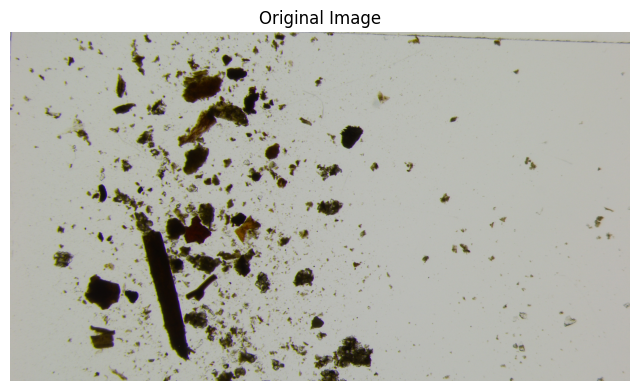

In [3]:
image_path = "data/input/233801-240125052635.jpg"
image = cv2.imread(image_path)
show_image(image, title="Original Image")

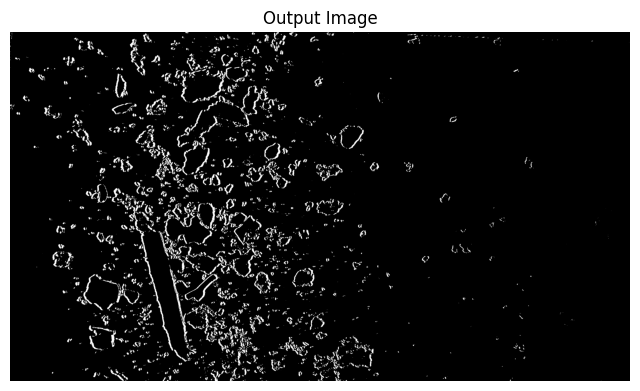

In [13]:
saturation_factor = 1.5

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv_image[:, :, 1] = cv2.multiply(hsv_image[:, :, 1], saturation_factor)
enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

lower_cyan = (30, 100, 100)
upper_cyan = (85, 255, 255)
lower_red = (130, 50, 50)
upper_red = (200, 255, 255)

mask_cyan = cv2.inRange(hsv_image, lower_cyan, upper_cyan)
mask_red = cv2.inRange(hsv_image, lower_red, upper_red)
mask = cv2.bitwise_or(mask_cyan, mask_red)

color_contour = cv2.bitwise_and(enhanced_image, enhanced_image, mask=mask)
color_contour[mask == 0] = [0, 0, 0]
color_contour[mask != 0] = [255, 255, 255]

show_image(color_contour, title="Output Image")

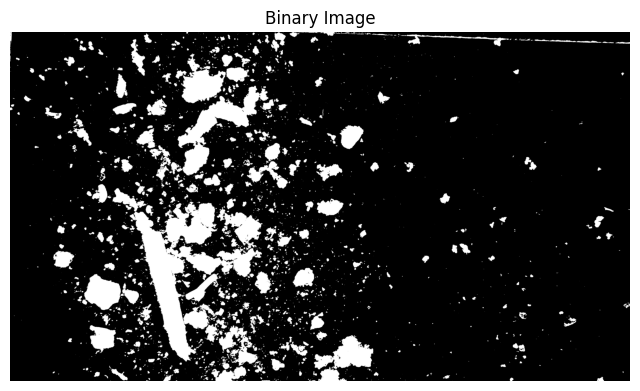

In [14]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 128+32, 255, cv2.THRESH_BINARY_INV)
show_image(binary, title="Binary Image")

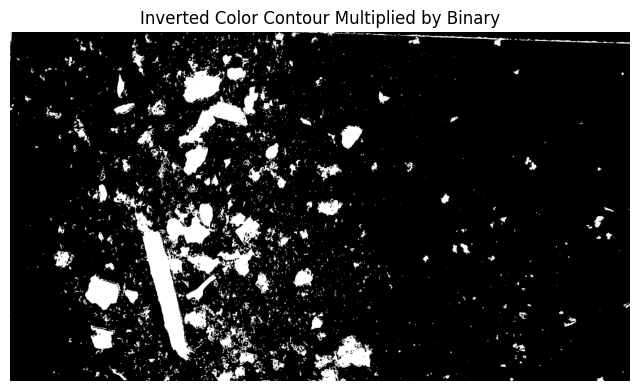

In [15]:
# Invert the color contour
inverted_color_contour = cv2.bitwise_not(color_contour)

# Multiply by the binary image
sharpened_binary = cv2.bitwise_and(inverted_color_contour, inverted_color_contour, mask=binary)

show_image(sharpened_binary, title="Inverted Color Contour Multiplied by Binary")

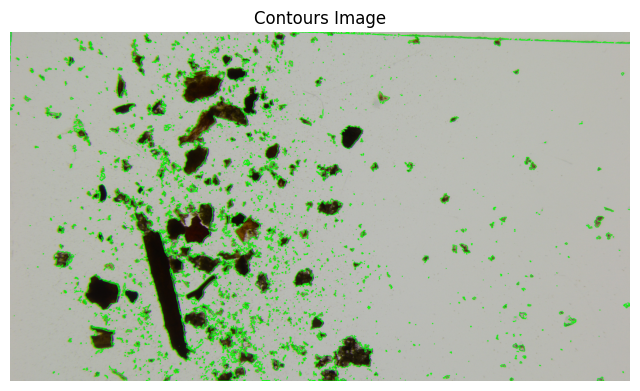

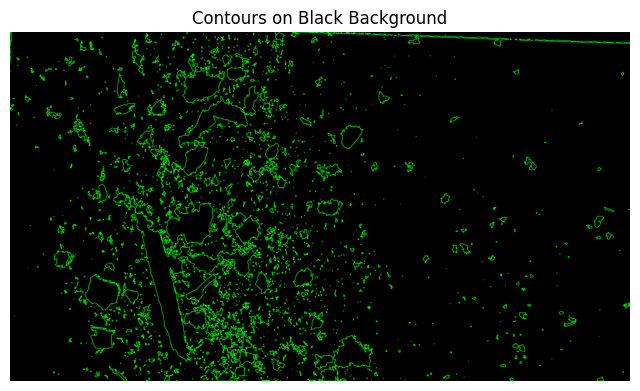

In [16]:
# Convert sharpened_binary to a single-channel image
sharpened_binary_gray = cv2.cvtColor(sharpened_binary, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(sharpened_binary_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = [contour for contour in contours if len(contour) >= 5]
contours_image = image.copy()
cv2.drawContours(contours_image, filtered_contours, -1, (0, 255, 0), 2)
show_image(contours_image, title="Contours Image")
# Create a black background image
black_background = np.zeros_like(image)

# Draw the filtered contours on the black background
cv2.drawContours(black_background, filtered_contours, -1, (0, 255, 0), 2)

# Show the image with contours over black background
show_image(black_background, title="Contours on Black Background")

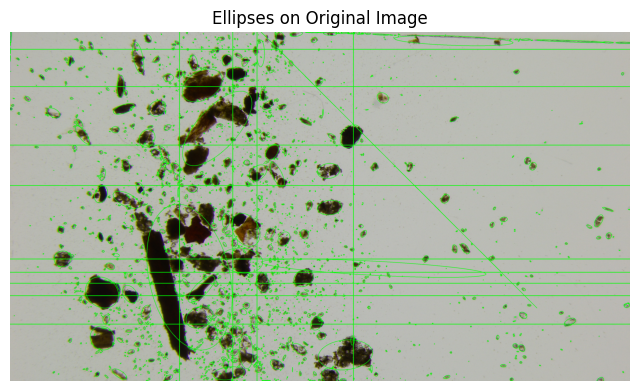

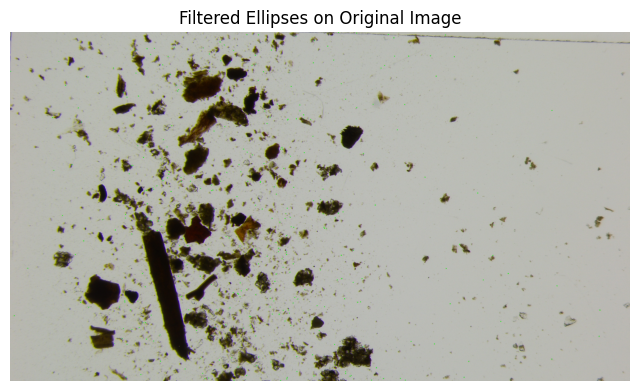